In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python3 (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.5.dev1
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/lisandro/Documents/mt/tp3
-- Configuring done
-- Generating done
-- Build files hav

In [2]:
import metnum
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import util
import math
import os 
import time

#### Leo el dataset

In [3]:
df = pd.read_csv('../data/train.csv')

In [4]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [5]:
df.info()
#variables numéricas:
# antiguedad, habitaciones, garages, banos, metroscubiertos, 
# metrostotales, gimnasio, usosmultiples, piscina, escuelascercanas, centroscomercialesceranos
#precio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

#### Creo un diccionario que contiene a las ciudades con menos de 20 inmuebles


In [6]:
dicc_ciudades = df['ciudad'].value_counts().to_dict()

dicc_pocas = {}

for x in dicc_ciudades:
    if dicc_ciudades[x] < 20:
        dicc_pocas[x] = True

#### Para las ciudades con menos de 20 inmuebles, cambiamos su nombre de ciudad a Resto, juntando todos esos inmuebles

In [7]:
for index in range(df.shape[0]):
    if df.loc[index, 'ciudad'] in dicc_pocas:
        df.loc[index, 'ciudad'] = 'Resto'

In [8]:
df['ciudad'].value_counts()

Querétaro                  12646
Benito Juárez              11014
Zapopan                    10360
San Luis Potosí             7925
Mérida                      7162
Monterrey                   6946
Alvaro Obregón              6633
Cuauhtémoc                  6614
Naucalpan de Juárez         6554
Miguel Hidalgo              5795
Atizapán de Zaragoza        5783
Tlalpan                     5721
Huixquilucan                5718
Coyoacán                    5293
Puebla                      4636
Guadalajara                 4006
San Andrés Cholula          3805
Cancún                      3779
Cuernavaca                  3775
Chihuahua                   3757
Tlalnepantla de Baz         3588
Cuautitlán Izcalli          3408
Tlajomulco de Zúñiga        3254
Gustavo A. Madero           3141
Iztapalapa                  3093
Cuajimalpa de Morelos       3020
Tijuana                     2863
Hermosillo                  2590
Resto                       2497
Acapulco de Juárez          2454
          

#### Creo la función que necesito para experimentar

In [35]:
#Tanto lista_atributos_predicen como atributo_a_predecir son listas de strings.

#No modifica el data frame que le pasamos como parámetro.

#arroja métricas segmentando el dataframe con la ciudad que pasamos como parámetro.

def métricas_regresión_ciudades(_df, ciudad, lista_atributos_predicen, atributo_a_predecir, porcentaje = 0.8):
    
    new_df = _df[_df['ciudad'] == ciudad]
    
    #Tiro las filas con Nan en algunas de las columnas que vamos a utilizar.
    lista_completa = lista_atributos_predicen.copy()
    lista_completa.append(atributo_a_predecir)
    new_df = new_df[lista_completa].dropna()
    
    n = len(new_df)
    limite = int(n*porcentaje)
    
    df_predicen_train = new_df[lista_atributos_predicen][0:limite]
    df_predecido_train = new_df[atributo_a_predecir][0:limite]
    
    df_predicen_test = new_df[lista_atributos_predicen][limite:]
    df_predecido_test = new_df[atributo_a_predecir][limite:]
    
    x_train = df_predicen_train.to_numpy()
    y_train = df_predecido_train.to_numpy()
    
    #x_train = x_train.reshape(x_train.shape[1], x_train.shape[0])
    y_train = y_train.reshape(len(y_train),1)
    
    x_test = df_predicen_test.to_numpy()
    y_test = df_predecido_test.to_numpy()
    
    #x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    y_test = y_test.reshape(len(y_test),1)
    
    linReg = metnum.LinearRegression()
    linReg.fit(x_train, y_train)
    pred = linReg.predict(x_test)

    return util.get_errors(pred, y_test)

#Arroja métricas para el data frame entero, sin segmentar por ciudad
    
def métricas_regresión(_df, lista_atributos_predicen, atributo_a_predecir, porcentaje = 0.8):
    
    new_df = _df
    
    #Tiro las filas con Nan en algunas de las columnas que vamos a utilizar.
    lista_completa = lista_atributos_predicen.copy()
    lista_completa.append(atributo_a_predecir)
    new_df = new_df[lista_completa].dropna()
    
    n = len(new_df)
    limite = int(n*porcentaje)
    
    df_predicen_train = new_df[lista_atributos_predicen][0:limite]
    df_predecido_train = new_df[atributo_a_predecir][0:limite]
    
    df_predicen_test = new_df[lista_atributos_predicen][limite:]
    df_predecido_test = new_df[atributo_a_predecir][limite:]
    
    x_train = df_predicen_train.to_numpy()
    y_train = df_predecido_train.to_numpy()
    
    #x_train = x_train.reshape(x_train.shape[1], x_train.shape[0])
    y_train = y_train.reshape(len(y_train),1)
    
    x_test = df_predicen_test.to_numpy()
    y_test = df_predecido_test.to_numpy()
    
    #x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    y_test = y_test.reshape(len(y_test),1)
    
    linReg = metnum.LinearRegression()
    linReg.fit(x_train, y_train)
    pred = linReg.predict(x_test)

    return util.get_errors(pred, y_test)



In [10]:
métricas_regresión_ciudades(df, 'Cuauhtémoc',  ['metrostotales','banos'], 'precio')

(1951661.7836798013, 0.631013864354211)

### Configuramos todo para la experimentación

In [50]:
lista_ciudades = df['ciudad'].unique().tolist()
#total = 244

variables_numéricas = ['metroscubiertos','antiguedad', 'habitaciones', 'garages', 'banos', 'metrostotales',
                       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']


#calculo las métricas para la predicción usando las primeras i (variando de 1 a 11) variables con Querétaro

lista_variables = []
rsme_Querétaro = []
rsmle_Querétaro = []


for variable in variables_numéricas:
    lista_variables.append(variable)
    rsme_Querétaro.append(métricas_regresión_ciudades(df, 'Querétaro',  lista_variables, 'precio')[0])
    rsmle_Querétaro.append(métricas_regresión_ciudades(df, 'Querétaro',  lista_variables, 'precio')[1])

lista_variables = []

#calculo las métricas para la predicción usando las primeras i (variando de 1 a 11) variables con Xochitepec
lista_variables = []
rsme_Xochitepec = []
rsmle_Xochitepec = []

for variable in variables_numéricas:
    lista_variables.append(variable)
    rsme_Xochitepec.append(métricas_regresión_ciudades(df, 'Xochitepec',  lista_variables, 'precio')[0])
    rsmle_Xochitepec.append(métricas_regresión_ciudades(df, 'Xochitepec',  lista_variables, 'precio')[1])

#calculo las métricas para la predicción usando las primeras i (variando de 1 a 11) variables con Resto
lista_variables = []
rsme_Resto = []
rsmle_Resto = []

for variable in variables_numéricas:
    lista_variables.append(variable)
    rsme_Resto.append(métricas_regresión_ciudades(df, 'Resto',  lista_variables, 'precio')[0])
    rsmle_Resto.append(métricas_regresión_ciudades(df, 'Resto',  lista_variables, 'precio')[1])

#calculo las métricas para todas las propiedades con precios > 

lista_variables = []
rsme_df = []
rsmle_df = []

for variable in variables_numéricas:
    lista_variables.append(variable)
    rsme_df.append(métricas_regresión(df[df['precio'] > 2000000],  lista_variables, 'precio')[0])
    rsmle_df.append(métricas_regresión(df[df['precio'] > 2000000],  lista_variables, 'precio')[1])



[0.39995720561600545,
 0.3940044114965931,
 0.3861342534159693,
 0.3756675051427215,
 0.3724042982273646,
 0.36196027738271314,
 0.35615773763112146,
 0.3558361525864214,
 0.35574114620775404,
 0.3557004812430843,
 0.3551129601178666]

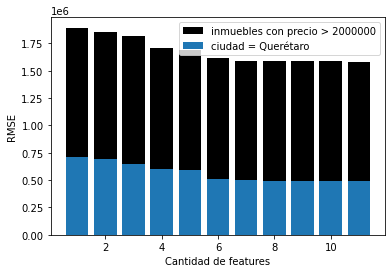

In [74]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsme_df, color = 'black')
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsme_Querétaro)
plt.xlabel('Cantidad de features')
plt.ylabel('RMSE')
plt.legend(['inmuebles con precio > 2000000', 'ciudad = Querétaro'])
plt.savefig('rmse_Querétaro')

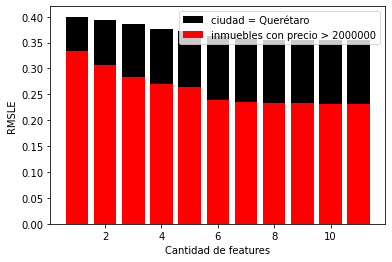

In [75]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsmle_df, color = 'black')
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsmle_Querétaro, color = 'red')
plt.xlabel('Cantidad de features')
plt.ylabel('RMSLE')
plt.legend(['ciudad = Querétaro', 'inmuebles con precio > 2000000'])
plt.savefig('rmsle_Querétaro')

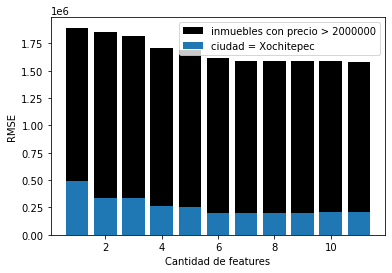

In [76]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsme_df, color = 'black')
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsme_Xochitepec)
plt.xlabel('Cantidad de features')
plt.ylabel('RMSE')
plt.legend(['inmuebles con precio > 2000000','ciudad = Xochitepec'])
plt.savefig('rmse_Xochitepec')

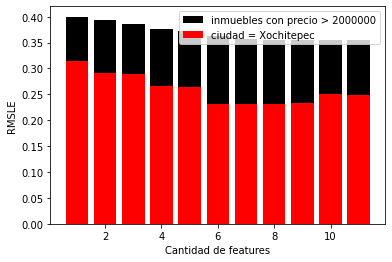

In [78]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsmle_df, color = 'black')
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsmle_Xochitepec, color = 'red')
plt.xlabel('Cantidad de features')
plt.ylabel('RMSLE')
plt.legend(['inmuebles con precio > 2000000','ciudad = Xochitepec'])
plt.savefig('rmsle_Xochitepec')

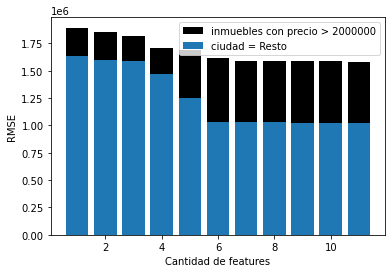

In [79]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsme_df, color = 'black')
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsme_Resto)
plt.xlabel('Cantidad de features')
plt.ylabel('RMSE')
plt.legend(['inmuebles con precio > 2000000','ciudad = Resto'])
plt.savefig('rmse_Resto')

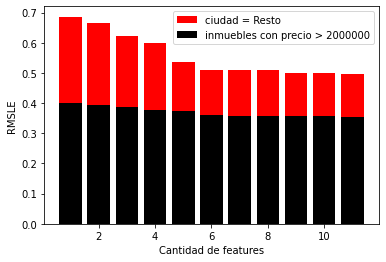

In [80]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsmle_Resto, color = 'red')
plt.bar([1,2,3,4,5,6,7,8,9,10,11],rsmle_df, color = 'black')
plt.xlabel('Cantidad de features')
plt.ylabel('RMSLE')
plt.legend(['ciudad = Resto','inmuebles con precio > 2000000'])
plt.savefig('rmsle_Resto')